### Final Project: LSH Plagiarism Detector
### CS-UY 3943: Mining Massive Dataset  
Zachary Zeng #nz900  
Simon Men: 

#### Final Report
* Detailed description your models
    * Describe what kinds of statistical methods and machine learning algorithms you used
    * How did you validate your models?
    * What other models did you consider, and why didn't you proceed with those?
    * Some suggested keywords are regression, classification, recommendations, cross-validation,
    overfitting, etc.
* What business applications do your findings have?
* Optionally, describe how your analyses would be implemented in a live system (e.g., a personal
recommendation system or a tweetbot). Where would the data live, how would you represent your
results, how would end-users access it? When would your model learn new parameters? Describe in
detail the pipeline from data ingestion to end-user experience

### Problem description adnd Hypotheis
In this project, we are trying to use Locality Sensitivity Hashing and MinHash to identify plagiarism based on content similarity. Note that, the plagiarism works we are trying to identify in this case are mostly exact copy and paste without parahprases, since other deep learning models are able to detect plagiarism with paraphrases and word replacements. In our case, given a set of source documents and a set of suspicious documents which include varying amount of contents from source documents, the model performs a binary classification on if the suspicious document contains plagiarism. 

In [14]:
from __future__ import division
import os
import pickle
import codecs
from glob import glob
import re
import numpy as np
import pandas as pd

In [5]:
DATA_SOURCE = "./source"
SUSPICIOUS_DOCS = "./test"
FILE_INFO = "file_info.csv"

### Dataset Description


* Description of your dataset and how it was obtained
    * Some basic statistics (# of rows, some aggregates)
    * What did you learn in the initial data exploration phase?
    * How did you decide what features to use in your analysis?
    * Description of any pre-processing steps you took

In [6]:
pd.read_csv(FILE_INFO)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
...,...,...,...
95,orig_taska.txt,a,orig
96,orig_taskb.txt,b,orig
97,orig_taskc.txt,c,orig
98,orig_taskd.txt,d,orig


In [25]:
glob(os.path.join(DATA_SOURCE, '*.txt')), glob(os.path.join(SUSPICIOUS_DOCS, '*.txt'))

(['./source/orig_taskd.txt',
  './source/orig_taske.txt',
  './source/orig_taska.txt',
  './source/orig_taskb.txt',
  './source/orig_taskc.txt'],
 ['./test/g0pC_taskc.txt',
  './test/g0pE_taskd.txt',
  './test/g0pE_taske.txt',
  './test/g0pC_taskb.txt',
  './test/g1pA_taske.txt',
  './test/g3pB_taskd.txt',
  './test/g3pB_taske.txt',
  './test/g0pC_taska.txt',
  './test/g1pA_taskd.txt',
  './test/g0pC_taske.txt',
  './test/g3pB_taska.txt',
  './test/g0pE_taskb.txt',
  './test/g0pE_taskc.txt',
  './test/g0pC_taskd.txt',
  './test/g1pA_taska.txt',
  './test/g1pA_taskc.txt',
  './test/g3pB_taskb.txt',
  './test/g0pE_taska.txt',
  './test/g3pB_taskc.txt',
  './test/g1pA_taskb.txt',
  './test/g2pA_taskb.txt',
  './test/g0pD_taskd.txt',
  './test/g0pB_taskc.txt',
  './test/g0pB_taskb.txt',
  './test/g0pD_taske.txt',
  './test/g2pA_taskc.txt',
  './test/g3pC_taskd.txt',
  './test/g2pA_taska.txt',
  './test/g0pB_taska.txt',
  './test/g3pC_taske.txt',
  './test/g3pC_taska.txt',
  './test/g2pA_ta

In [1]:
try:
    from datasketch import MinHash, MinHashLSH
    import nltk
    import pickle
except:
    %pip install datasketch
    %pip install nltk
    %pip install pickle

In [20]:
from nltk.tokenize import wordpunct_tokenize
import re


### Preprocessing

In [54]:
def read_file(file_name: str) -> str:
    """
    Read text files to strings by different encoding modes in case of exception
    """
    try:
        text = codecs.open(file_name).read()
    except UnicodeDecodeError:
        text = codecs.open(file_name, encoding='cp1252').read()
    except FileNotFoundError:
        text = ""
    return text

def create_dataset_df(file_info: str, docs_dir: str) -> pd.DataFrame:
    """
    Creates a Pandas dataframe from file info, with cells with text content and binary labels on if the text includes plagiarism
    """
    df = pd.read_csv(file_info)
    df['Text'] = np.array([read_file(os.path.join(docs_dir, file)) for file in df["File"]])
    df["Label"] = (df["Category"]!="non")
    df = df[df["Category"]!="orig"]
    df = df.drop(columns=['Category'])
    return df

In [55]:
data_df = create_dataset_df(FILE_INFO, SUSPICIOUS_DOCS)
data_df

,File,Task,Text,Label
0,g0pA_taska.txt,a,Inheritance is a basic concept of Object-Orien...,False
1,g0pA_taskb.txt,b,PageRank is a link analysis algorithm used by ...,True
2,g0pA_taskc.txt,c,"The vector space model (also called, term vect...",True
3,g0pA_taskd.txt,d,Bayes’ theorem was names after Rev Thomas Baye...,True
4,g0pA_taske.txt,e,Dynamic Programming is an algorithm design tec...,False
...,...,...,...,...
90,g4pE_taska.txt,a,Object oriented programming is a style of pro...,True
91,g4pE_taskb.txt,b,PageRankalgorithm is also known as link analys...,True
92,g4pE_taskc.txt,c,The definition of term depends on the applicat...,True
93,g4pE_taskd.txt,d,"""Bayes' Theorem"" or ""Bayes' Rule"", or somethin...",False


In [84]:
X = data_df["Text"].values
y = data_df["Label"].values

array([False,  True,  True,  True, False, False, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False, False,  True, False,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
       False,  True,  True, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False, False])

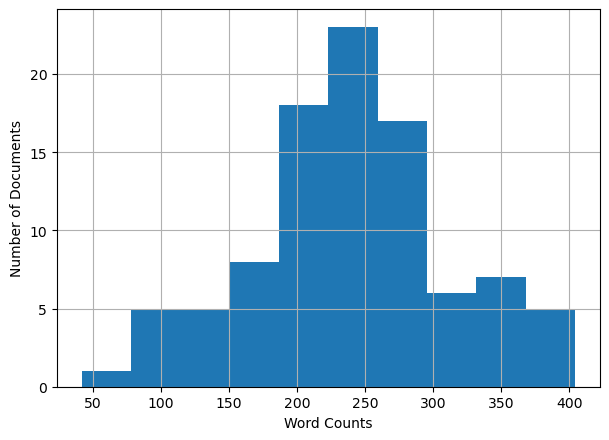

In [72]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["figure.dpi"] = 100
plt.grid()
word_counts = np.array([len(wordpunct_tokenize(text))for text in data_df["Text"]])
plt.hist(word_counts)
plt.xlabel("Word Counts")
plt.ylabel("Number of Documents")
plt.show()

In [80]:
print(f"""Average Word Counts:\t{np.average(word_counts).round(2)}
Standard Deviation:\t{np.std(word_counts).round(2)}""")

Average Word Counts:	239.56
Standard Deviation:	75.01


### LSH model

In [45]:
def create_minhash(text: str, n_gram: int, num_perm=128) -> MinHash:
    """
    Tokenize text in N-grams, removes punctuations, and generates minhash from a text given ngrams and number of permutations
    """
    tokens = wordpunct_tokenize(text)
    minhash = MinHash(num_perm=num_perm)
    for gram in nltk.ngrams(tokens, n_gram):
        minhash.update(" ".join(gram).encode('utf-8')) 
    return minhash

def create_lsh(source_dir, threshold=.3, n_gram=3, num_perm=128) -> MinHashLSH:
    """
    Create an LSH instance from text files in source directory given threshold, n-grams, and number of permutation
    Returns an LSH object and a list of source file numbers 
    """
    lsh = MinHashLSH(num_perm=num_perm, threshold=threshold)
    file_names = glob(os.path.join(source_dir, '*.txt'))
    file_names.sort()
    keys = []
    minhashes = []
    for fname in file_names:
        text = read_file(fname)
        minhash = create_minhash(text, n_gram, num_perm=num_perm)
        keys.append(os.path.basename(fname))
        minhashes.append(minhash)
    with lsh.insertion_session() as session:
        for key, minhash in zip(keys, minhashes):
            session.insert(key, minhash)
    return lsh, keys



In [46]:
lsh, keys = create_lsh(DATA_SOURCE)

### Model Evaluation

In [85]:
def eval_single(lsh: MinHashLSH, text: str, n_gram: int, num_perm=128):
    """
    Evaluate a single text to a MinHashLSH instance given number of grams and permutations
    """
    minhash = create_minhash(text, n_gram, num_perm=num_perm)
    result = lsh.query(minhash)
    return len(result)>0

def eval_list(lsh: MinHashLSH, texts: np.array, n_gram: int, num_perm: int)-> np.array:
    """
    Given an array of texts, return a boolean array of binary classification
    """
    results = []
    for text in texts:
        results.append(eval_single(lsh, text, n_gram, num_perm=num_perm))
    return np.array(results)

y_pred = eval_list(lsh, data_df["Text"], 3, 128)

### Testing

In [87]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, precision_recall_curve

In [88]:
accuracy_score(y, y_pred)

0.631578947368421

In [91]:
n_gram = 3
jaccard_th = .05
num_perm = 128

#### Parameter Tuning

In [97]:
for n_gram in range(1, 10):
    for jaccard_th in [.2]:
        lsh, keys = create_lsh(DATA_SOURCE, n_gram=n_gram, threshold=jaccard_th, num_perm=num_perm)
        results = eval_list(lsh,X, n_gram, num_perm)
        print(f'{n_gram} grams, {jaccard_th} < jaccard, accuracy: {accuracy_score(y, results)}')


1 grams, 0.2 < jaccard, accuracy: 0.6526315789473685
2 grams, 0.2 < jaccard, accuracy: 0.8
3 grams, 0.2 < jaccard, accuracy: 0.7473684210526316
4 grams, 0.2 < jaccard, accuracy: 0.6736842105263158
5 grams, 0.2 < jaccard, accuracy: 0.7052631578947368
6 grams, 0.2 < jaccard, accuracy: 0.6631578947368421
7 grams, 0.2 < jaccard, accuracy: 0.631578947368421
8 grams, 0.2 < jaccard, accuracy: 0.6
9 grams, 0.2 < jaccard, accuracy: 0.6105263157894737
